In [1]:
import urllib.request
import os
import tarfile
import tensorflow as tf

In [2]:
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filepath = 'data/cifar-10-python.tar.gz'
if not os.path.isfile(filepath):
    result=urllib.request.urlretrieve(url,filepath)
    print('downloaded:',result)
else:
    print('Data file already exists.')
    
if not os.path.exists("data/cifar-10-batches-py"):
    tfile=tarfile.open("data/cifar-10-python.tar.gz",'r:gz')
    result=tfile.extractall('data/')
    print('Extracted to ./data/cifar-10-batches-py/')
else:
    print('Directory already exists.')

Data file already exists.
Directory already exists.


In [3]:
import os
import numpy as np
import pickle as p

In [4]:
def load_CIFAR_batch(filename):
    """load single batch of cifar"""
    
    with open(filename,'rb')as f:
        data_dict = p.load(f,encoding='bytes')
        images=data_dict[b'data']
        labels=data_dict[b'labels']
        images = images.reshape(10000,3,32,32)
        images = images.transpose(0,2,3,1)
        labels=np.array(labels)
        return images,labels

In [5]:
def load_CIFAR_data(data_dir):
    images_train=[]
    labels_train=[]
    for i in range(5):
        f=os.path.join(data_dir,'data_batch_%d'%(i+1))
        print('loading',f)
        image_batch,label_batch=load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain=np.concatenate(images_train)
        Ytrain=np.concatenate(labels_train)
        del image_batch,label_batch
        
    Xtest,Ytest = load_CIFAR_batch(os.path.join(data_dir,'test_batch'))
    print('finished loadding CIFAR-10 data')
    
    return Xtrain,Ytrain,Xtest,Ytest


In [6]:
data_dir= 'data/cifar-10-batches-py/'
Xtrain,Ytrain,Xtest,Ytest=load_CIFAR_data(data_dir)

loading data/cifar-10-batches-py/data_batch_1
loading data/cifar-10-batches-py/data_batch_2
loading data/cifar-10-batches-py/data_batch_3
loading data/cifar-10-batches-py/data_batch_4
loading data/cifar-10-batches-py/data_batch_5
finished loadding CIFAR-10 data


In [7]:
print('training data shape:',Xtrain.shape)
print('training labels shape:',Ytrain.shape)
print('test data shape:',Xtest.shape)
print('test labels shape:',Ytest.shape)

training data shape: (50000, 32, 32, 3)
training labels shape: (50000,)
test data shape: (10000, 32, 32, 3)
test labels shape: (10000,)


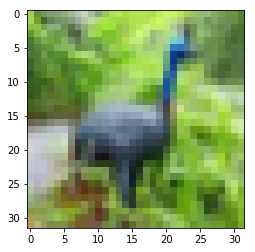

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(Xtrain[6])

In [9]:
print(Ytrain[6])

2


In [10]:
import matplotlib.pyplot as plt
label_dict={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
            5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig=plt.gcf()
    fig.set_size_inches(12,6)
    if num>10:
        num=10
    for idx in range(0,num):
        ax=plt.subplot(2,5,1+idx)
        ax.imshow(images[idx],cmap='binary')
        
        title=str(idx)+','+label_dict[labels[idx]]
        if len(prediction)>0:
            title+='=>'+label_dict[prediction[idx]]
            
        ax.set_title(title,fontsize=10)
        idx+=1
    plt.show()

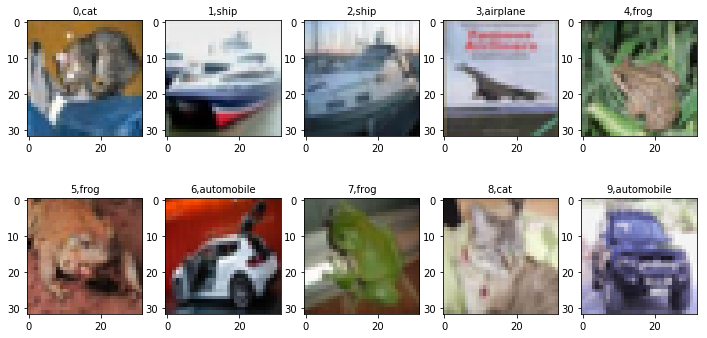

In [11]:
plot_images_labels_prediction(Xtest,Ytest,[],0,10)

In [12]:
Xtrain[0][0][0]

array([59, 62, 63], dtype=uint8)

In [13]:
Xtrain_normalize=Xtrain.astype('float32')/255.0
Xtest_normalize=Xtest.astype('float32')/255.0

In [14]:
Xtrain_normalize[0][0][0]

array([ 0.23137255,  0.24313726,  0.24705882], dtype=float32)

In [15]:
Ytrain[:10]

array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

In [16]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(sparse=False)
yy=[[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
encoder.fit(yy)
Ytrain_reshape=Ytrain.reshape(-1,1)
Ytrain_onehot=encoder.transform(Ytrain_reshape)
Ytest_reshape=Ytest.reshape(-1,1)
Ytest_onehot=encoder.transform(Ytest_reshape)

C:\Users\ausu\AppData\Roaming\Python\Python36\site-packages\scipy\__init__.py:115: UserWarning: Numpy 1.13.3 or above is required for this version of scipy (detected version 1.13.1)
  UserWarning)
D:\Anaconda\envs\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [17]:
Ytrain_onehot.shape

(50000, 10)

In [18]:
Ytrain[:5]

array([6, 9, 9, 4, 1])

In [19]:
Ytrain_onehot[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [20]:
#定义权值
#在训练时，这个变量不断更新
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.1),name='W')

#偏置项
#初始化为0.1
def bias(shape):
    return tf.Variable(tf.constant(0.1,shape=shape),name='b')

#定义卷积操作
#步长为1，padding为‘SAME’
def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

#定义池化操作
#步长为2，即原尺寸的长和宽各除以2
def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')


In [24]:
#输入层
with tf.name_scope('input_layer'):
    x = tf.placeholder('float',shape=[None,32,32,3],name="x")

In [25]:
#第一个卷积层
#输入通道：3，输出通道：32，卷积后图像尺寸不变，依然是32x32
with tf.name_scope('conv_1'):
    W1 = weight([3,3,3,32])#[k_width,k_height,input_chn,output_chn]
    b1 = bias([32])#与output_chn一致
    conv_1=conv2d(x,W1)+b1
    conv_1=tf.nn.relu(conv_1)

In [27]:
#第一个池化层
#将32x32图像缩小为16x16，池化不改变通道数量，依然是32个
with tf.name_scope('pool_1'):
    pool_1=max_pool_2x2(conv_1)

In [29]:
#第二个卷积层
#输入通道：32，输出通道：64，卷积后图像尺寸不变，依然是16x16
with tf.name_scope('conv_2'):
    W2 = weight([3,3,32,64])
    b2 = bias([64])
    conv_2=conv2d(pool_1,W2)+b2
    conv_2=tf.nn.relu(conv_2)    

In [30]:
#第二个池化层
#将32x32图像缩小为8x8，池化不改变通道数量，依然是64个
with tf.name_scope('pool_2'):
    pool_2=max_pool_2x2(conv_2)

In [31]:
#全连接层
#将第二个池化层的64个8x8的图像转换为一维的向量，长度是64*8*8=4096
#128个神经元
with tf.name_scope('fc'):
    W3 = weight([4096,128])#有128个神经元
    b3 = bias([128])#与output_chn一致
    flat=tf.reshape(pool_2,[-1,4096])
    h=tf.nn.relu(tf.matmul(flat,W3+b3))
    h_dropout = tf.nn.dropout(h,keep_prob=0.8)

In [33]:
#输出层共有10个神经元，对应到0-9这10个类别
with tf.name_scope('output_layer'):
    W4 = weight([128,10])
    b4 = bias([10])
    pred = tf.nn.softmax(tf.matmul(h_dropout,W4)+b4)

In [50]:
with tf.name_scope('optimizer'):
    y = tf.placeholder("float",shape=[None,10],name="label")
    loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y))
    optimizer=tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_function)
    

In [51]:
with tf.name_scope("evaluation"):
    correct_prediction = tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))

In [52]:
import os
from time import time

train_epoch = 35
batch_size=50
total_batch=int(len(Xtrain)/batch_size)
epoch_list=[];accuracy_list=[];loss_list=[];

epoch=tf.Variable(0,name='epoch',trainable=False)
startTime=time()

sess=tf.Session()
init=tf.global_variables_initializer()
sess.run(init)

In [53]:
#设置检查点存储目录
ckpt_dir='CIFAR10_log/'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
    
#生成saver
saver=tf.train.Saver(max_to_keep=1)

#如果有检查点文件，读取最新的检查点文件，恢复各种变量值
ckpt=tf.train.latest_checkpoint(ckpt_dir)
if ckpt!=None:
    saver.restore(sess,ckpt)#加载所有的参数
    #从这里开始就可以直接使用模型进行预测，或者接着训练了
else:
    print("Training from scratch.")

#获取续训参数
start=sess.run(epoch)
print("Training starts from {} epoch.".format(start+1))

INFO:tensorflow:Restoring parameters from CIFAR10_log/CIFAR10_cnn_model.cpkt-25


NotFoundError: Key conv_1_2/W/Adam_2 not found in checkpoint
	 [[Node: save_3/RestoreV2_7 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_3/Const_0_0, save_3/RestoreV2_7/tensor_names, save_3/RestoreV2_7/shape_and_slices)]]

Caused by op 'save_3/RestoreV2_7', defined at:
  File "D:\Anaconda\envs\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Anaconda\envs\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Anaconda\envs\python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Anaconda\envs\python36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Anaconda\envs\python36\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "D:\Anaconda\envs\python36\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "D:\Anaconda\envs\python36\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "D:\Anaconda\envs\python36\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda\envs\python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "D:\Anaconda\envs\python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Anaconda\envs\python36\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "D:\Anaconda\envs\python36\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda\envs\python36\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Anaconda\envs\python36\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Anaconda\envs\python36\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "D:\Anaconda\envs\python36\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Anaconda\envs\python36\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Anaconda\envs\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Anaconda\envs\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Anaconda\envs\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-53-adcc45a13d6d>", line 7, in <module>
    saver=tf.train.Saver(max_to_keep=1)
  File "D:\Anaconda\envs\python36\lib\site-packages\tensorflow\python\training\saver.py", line 1139, in __init__
    self.build()
  File "D:\Anaconda\envs\python36\lib\site-packages\tensorflow\python\training\saver.py", line 1170, in build
    restore_sequentially=self._restore_sequentially)
  File "D:\Anaconda\envs\python36\lib\site-packages\tensorflow\python\training\saver.py", line 691, in build
    restore_sequentially, reshape)
  File "D:\Anaconda\envs\python36\lib\site-packages\tensorflow\python\training\saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "D:\Anaconda\envs\python36\lib\site-packages\tensorflow\python\training\saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "D:\Anaconda\envs\python36\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 640, in restore_v2
    dtypes=dtypes, name=name)
  File "D:\Anaconda\envs\python36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "D:\Anaconda\envs\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "D:\Anaconda\envs\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key conv_1_2/W/Adam_2 not found in checkpoint
	 [[Node: save_3/RestoreV2_7 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_3/Const_0_0, save_3/RestoreV2_7/tensor_names, save_3/RestoreV2_7/shape_and_slices)]]


In [54]:
def get_train_batch(number,batch_size):
    return Xtrain_normalize[number*batch_size:(number+1)*batch_size],Ytrain_onehot[number*batch_size:(number+1)*batch_size]

In [55]:
for ep in range(start,train_epoch):
    for i in range(total_batch):
        batch_x,batch_y=get_train_batch(i,batch_size)
        sess.run(optimizer,feed_dict={x:batch_x,y:batch_y})
        if i % 100 == 0:
            print("Step{}".format(i),"finished.")
            
    loss,acc=sess.run([loss_function,accuracy],feed_dict={x:batch_x,y:batch_y})
    epoch_list.append(ep+1)
    loss_list.append(loss)
    accuracy_list.append(acc)
    
    print("Train epoch:",'%02d' % (sess.run(epoch)+1),"Loss=","{:.6f}".format(loss),"Accuracy=",acc)
    
    #保存检查点
    saver.save(sess,ckpt_dir+"CIFAR10_cnn_model.cpkt",global_step=ep+1)
    sess.run(epoch.assign(ep+1))

duration=time()-startTime
print("Train finished takes:",duration)

Step0 finished.
Step100 finished.
Step200 finished.
Step300 finished.
Step400 finished.
Step500 finished.
Step600 finished.
Step700 finished.
Step800 finished.
Step900 finished.
Train epoch: 01 Loss= 1.985720 Accuracy= 0.44
Step0 finished.
Step100 finished.
Step200 finished.
Step300 finished.
Step400 finished.
Step500 finished.
Step600 finished.
Step700 finished.
Step800 finished.
Step900 finished.
Train epoch: 03 Loss= 1.975178 Accuracy= 0.44
Step0 finished.
Step100 finished.
Step200 finished.
Step300 finished.
Step400 finished.
Step500 finished.
Step600 finished.
Step700 finished.
Step800 finished.
Step900 finished.
Train epoch: 04 Loss= 1.981017 Accuracy= 0.46
Step0 finished.
Step100 finished.
Step200 finished.
Step300 finished.
Step400 finished.
Step500 finished.
Step600 finished.
Step700 finished.
Step800 finished.
Step900 finished.
Train epoch: 05 Loss= 1.932829 Accuracy= 0.52
Step0 finished.
Step100 finished.
Step200 finished.
Step300 finished.
Step400 finished.
Step500 finished

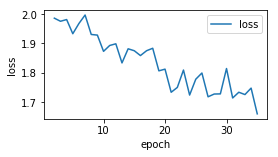

In [56]:
%matplotlib inline

fig=plt.gcf()
fig.set_size_inches(4,2)
plt.plot(epoch_list,loss_list,label='loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'],loc='upper right')

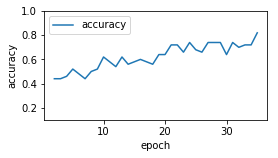

In [57]:
plt.plot(epoch_list,accuracy_list,label='accuracy')
fig=plt.gcf()
fig.set_size_inches(4,2)
plt.ylim(0.1,1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [58]:
test_total_batch = int(len(Xtest_normalize)/batch_size)
test_acc_sum=0.0
for i in range(test_total_batch):
    test_image_batch=Xtest_normalize[i*batch_size:(i+1)*batch_size]
    test_label_batch=Ytest_onehot[i*batch_size:(i+1)*batch_size]
    test_batch_acc=sess.run(accuracy,feed_dict={x:test_image_batch,y:test_label_batch})
    test_acc_sum+=test_batch_acc
test_acc=float(test_acc_sum/test_total_batch)
print("Test accuracy:{:.6f}".format(test_acc))


Test accuracy:0.666100


In [59]:
test_pred=sess.run(pred,feed_dict={x:Xtest_normalize[:10]})
prediction_result=sess.run(tf.argmax(test_pred,1))

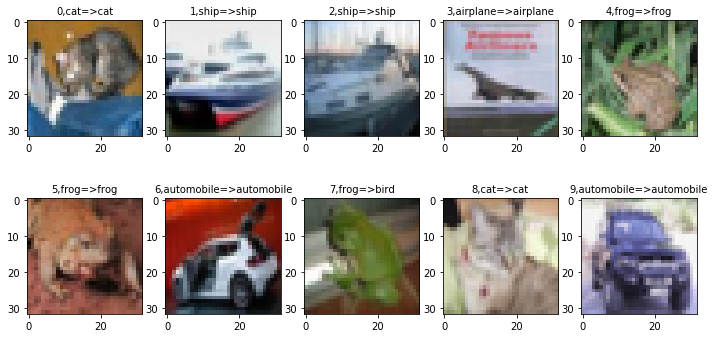

In [60]:
plot_images_labels_prediction(Xtest,Ytest,prediction_result,0,10)